Теория игр – это теория математических моделей принятия оптимальных решений в условиях конфликта или неопределённости. При этом конфликт не обязательно должен быть антагонистическим, в качестве конфликта можно рассматривать любое разногласие. Всякая теоретико-игровая модель должна отражать, кто и как конфликтует, а также, кто и в какой форме заинтересован в том или ином исходе конфликта. Действующие в конфликте стороны называются игроками, а решения, которые способны принимать игроки, стратегии. 
Рассмотрим матричные игры. Под матричной игрой понимается такая игра двух игроков, при которой каждый игрок имеет конечное число возможных ходов – чистых стратегий. При этом выигрыш одного игрока и проигрыш другого при применении ими определённых чистых стратегий выражается числом. Задачей теории игр является определение оптимальных стратегий игроков. В матричной игре оптимальной для игрока А называется стратегия, которая при многократном повторении игры обеспечивает максимально возможный средний выигрыш, а для игрока В под оптимальной понимается стратегия, обеспечивающая ему минимальный средний проигрыш. При этом предполагается, что противник является по меньшей мере таким же разумным и делает всё для того, чтобы помешать нам добиться своей цели.


Импортируем библиотеки:

In [36]:
import json
import math
import typing as tp
import numpy as np

Реализуем возможность ввода данных из файла в формате JSON, а также преобразуем считанные данные в платежную матрицу:

In [40]:
def load_json_data(filename: str) -> tp.Any:
    with open(filename, 'r') as file:
        data = json.load(file)
    return data

def transform_data_to_game_matrix(data: tp.Any) -> np.ndarray:
    arr = np.array([0] * len(data['matrix'][0]))
    for row in data['matrix']:
        arr = np.vstack([arr, row])
    return np.delete(arr, 0, 0)

Если игра m×n не имеет седловой точки, то найти её решение, особенно при больших m и n, трудно. Иногда эту задачу можно упростить, сократив число стратегий, вычёркивая некоторые заведомо невыгодные. 
Рассмотрим две стратегии первого игрока – i – ю и k – ю. При этом пусть для всех элементов соответствующих строк матрицы выполняются условия: 

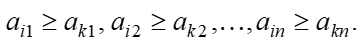

В этом случае говорят, что i – я стратегия первого игрока доминирует над его j – й стратегией. Если каждое неравенство выполняется как строгое, то говорят, что одна стратегия строго доминирует над другой. В любом случае из двух стратегий первый игрок предпочтет доминирующую, поскольку при использовании доминируемой стратегии его выигрыш по меньшей мере не увеличится.
Аналогично рассмотрим две стратегии второго игрока - j - ю и  l – ю, и при этом для элементов соответствующих столбцов матрицы выполняются условия:

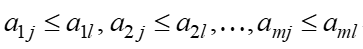

Для второго игрока, как известно, более выгодной является стратегия, дающая меньший проигрыш, поэтому говорят, что j - я стратегия доминирует над l - й. Если попарные неравенства являются строгими, то говорят, что одна стратегия строго доминирует над другой.
В результате при наличии доминирующих стратегий часть стратегий можно не рассматривать, что приведет в ряде случаев к значительному упрощению платежной матрицы.
Упростим платежную матрицу путем анализа доминирующих стратегий.

In [41]:
def find_strategies_to_delete_for_player_a(game_matrix: np.ndarray) -> set[int]:
    strategies_to_delete: set[int] = set()
    for i in range(game_matrix.shape[0]):
        if i not in strategies_to_delete:
            row = game_matrix[i]
            for j in range(game_matrix.shape[0]):
                if i != j and all(row >= game_matrix[j]):
                    strategies_to_delete.add(j)
    return strategies_to_delete

def find_strategies_to_delete_for_player_b(game_matrix: np.ndarray) -> set[int]:
    strategies_to_delete: set[int] = set()
    for i in range(game_matrix.shape[1]):
        if i not in strategies_to_delete:
            column = game_matrix[:, i]
            for j in range(game_matrix.shape[1]):
                if i != j and all(column <= game_matrix[:, j]):
                    strategies_to_delete.add(j)
    return strategies_to_delete

def simplify_matrix(game_matrix: np.ndarray) -> np.ndarray:
    strategies_to_delete = list(find_strategies_to_delete_for_player_a(game_matrix))
    simplified_matrix = game_matrix
    simplified_matrix = np.delete(simplified_matrix, strategies_to_delete, 0)
    strategies_to_delete = list(find_strategies_to_delete_for_player_b(simplified_matrix))
    simplified_matrix = np.delete(simplified_matrix, strategies_to_delete, 1)
    return simplified_matrix

Далее разберемся как находить нижнюю и верхнюю границы игры.
Рассмотрим матричную игру m×n с платежной матрицей:

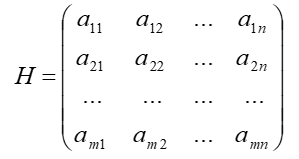

Пусть игрок А выбирает некоторую стратегию $А_i$, тогда в наихудшем случае он получит выигрыш равный min $a_{ij}$. Предвидя эту возможность, игрок А должен выбрать такую стратегию, чтобы максимизировать свой минимальный в каждой стратегии выигрыш α. Таким образом, α = max min $a_{ij}$. Величина α называется нижней ценой игры.
Очевидно, α находится в одной из строк матрицы Н, пусть в $i_0$, тогда стратегия $A_{i_0}$ называется максиминной.
Итак, если игрок А будет придерживаться максиминной стратегии, то ему при любом поведении игрока В гарантируется выигрыш, во всяком случае не меньше α.
С другой стороны, противник – игрок В, заинтересован в том, чтобы обратить выигрыш игрока А в минимум, поэтому он должен пересмотреть каждую свою стратегию с точки зрения максимального выигрыша игроком А при этой стратегии. Другими словами, при выборе некоторой стратегии $B_j$ он должен исходить из максимального проигрыша в этой стратегии, равного max $a_{ij}$, и найти такую стратегию, при которой этот проигрыш будет наименьшим, то есть не более чем β = max min $a_{ij}$.
Величина β называется верхней ценой игры, а соответствующая ему стратегия $B_{i_0}$ – минимаксной.


Игра с седловой точкой является наиболее простым случаем матричной игры. Игрой с седловой точкой называется игра, у которой совпадают нижняя и верхняя цены игры, то есть выполняется равенство:

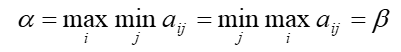

При этом V = α = β называется ценой игры, элемент $a_{i_0j_0}$ соответствующий равенству, называют седловой точкой.
Простота решения игры с седловой точкой заключается в том, что оптимальные стратегии обоих игроков находятся сразу. Для игрока А это стратегия $A_{i_0}$ для игрока В – $B_{i_0}$. Причём, такое решение обладает свойством устойчивости в том смысле, что если один из игроков применяет свою оптимальную стратегию, то любое отклонение другого игрока от оптимальной стратегии может оказаться не выгодным для него.


Попробуем определить нижнюю и верхнюю границы игры:

In [42]:
def find_lower_game_price(game_matrix: np.ndarray) -> tuple[int, int]:
    min_row_elements: list[int] = []
    for i in range(game_matrix.shape[0]):
        row = game_matrix[i]
        min_row_elements.append(min(row))
    max_min = max(min_row_elements)
    index = min_row_elements.index(max_min)
    return max_min, index

def find_upper_game_price(game_matrix: np.ndarray) -> tuple[int, int]:
    max_column_elements: list[int] = []
    for i in range(game_matrix.shape[1]):
        row = game_matrix[:, i]
        max_column_elements.append(max(row))
    min_max = min(max_column_elements)
    index = max_column_elements.index(min_max)
    return min_max, index

Среди конечных игр, имеющих практическое значение, сравнительно редко встречаются игры с седловой точкой. Более типичным является случай, когда нижняя и верхние цены не совпадают, причем α < β.
Установленный факт означает, что если игра одноходовая, то есть партнёры играют один раз, выбирая по одной чистой стратегии, то в расчёте на разумно играющего противника они должны придерживаться принципа минимакса, это гарантирует выигрыш V ≥ α игроку А и проигрыш V ≤ β игроку В. Следовательно, при применении минимаксных стратегий величина платежа V ограничена неравенством

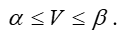

Если же игра повторяется не однократно, то постоянное применение минимаксных стратегий становится не разумным. Например, если игрок В будет уверен в том, что на следующем ходу А применит прежнюю стратегию, то он несомненно выберет стратегию, отвечающую наименьшему в это строке, а не прежнюю.
Таким образом, мы пришли к выводу, что при неоднократном повторении игры обоим игрокам следует менять свои стратегии. Тогда возникает вопрос: а каким образом их менять, чтобы в среднем выигрыш одного и проигрыш другого был аналогично одноходовой игре, ограничиваясь снизу и сверху соответственно?

Для ответа на этот вопрос введём вероятность (относительную частоту) $x_i$ применение игроком А i-й стратегии, и $y_i$ – вероятность применения j-й стратегии игроком В. Совокупности этих вероятностей определяют векторы:

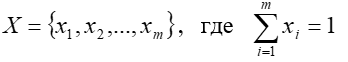
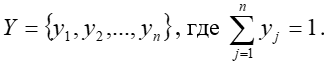

Эти векторы или наборы вероятностей выбора чистых стратегий называются смешанными стратегиями игроков. Для получения ограничений на средний выигрыш или проигрыш рассмотрим математическое ожидание выигрыша первого игрока:

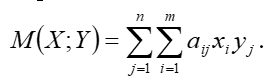

Если  второй игрок В выбрал некоторую смешанную стратегию $Y'$, то первому игроку, естественно, считать лучшей ту смешанную стратегию $\overline{X}$, при которой достигается max $M(X;Y')$:

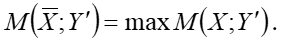

Аналогично, при выборе первым игроком некоторой стратегии $X'$ второму игроку следует выбирать стратегию $\overline{Y}$ такую, что:

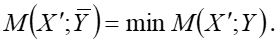

Ясно, что $X'$ зависит от $Y'$ и $\overline{Y}$ зависит от $X'$. Перед каждым игроком, таким образом, возникает задача выбора оптимальной стратегии, под которой для игрока А понимается смешанная стратегия $X^*$, которая максимизирует математическое ожидание его выигрыша, для игрока В – стратегия $Y^*$, минимизирующая математическое ожидание его проигрыша. Средняя величина выигрыша (математическое ожидание выигрыша) является функцией от смешанных стратегий и называется платежной функцией игры:

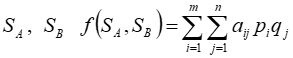

Чтобы определить смешанные стратегии и соответствующую цену игры с помощью симплекс-метода, необходимо составить двойственную задачу линейного программирования и решить её:

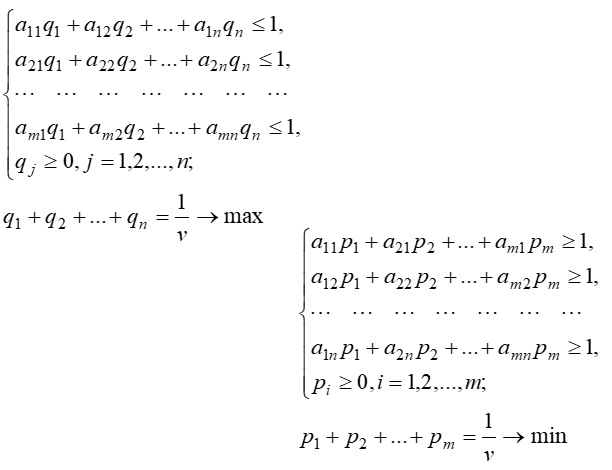

Прменим симплекс-метод из прошлой лабораторной работы:

In [43]:
def get_simplex_method_data(game_matrix: np.ndarray, goal: str, type: str) -> dict[str, tp.Any]:
    simplex_method_data: dict[str, tp.Any]= {}
    simplex_method_data["f"] = [1]*game_matrix.shape[1]
    simplex_method_data["goal"] = goal
    constraints: list[dict[str, tp.Any]] = []
    if goal == "min" and type == "gte":
        game_matrix = game_matrix.transpose()
    for i in range(game_matrix.shape[0]):
        constraint: dict[str, tp.Any] = {}
        coefs: list[int] = []
        for j in range(game_matrix.shape[1]):
            coefs.append(game_matrix[i][j])
        constraint["coefs"] = coefs
        constraint["type"] = type
        constraint["b"] = 1
        constraints.append(constraint)
    simplex_method_data["constraints"] = constraints
    return simplex_method_data

def transform_to_canonical_form(data):
    constraints = data["constraints"]
    num_original_vars = len(data["f"])
    num_constraints = len(constraints)
    
    constraint_matrix = []
    right_hand_side_values = []

    for constraint in constraints:
        if constraint["type"] == "gte":
            constraint["coefs"] = [-coef for coef in constraint["coefs"]]
            constraint["b"] = -constraint["b"]
    
    for idx, constraint in enumerate(constraints):
        coefs = constraint["coefs"] + [0] * num_constraints
        if constraint["type"] in ["lte", "gte"]:
            coefs[num_original_vars + idx] = 1
        constraint_matrix.append(coefs)
        right_hand_side_values.append(constraint["b"])

    for idx in reversed(range(num_original_vars, num_original_vars + num_constraints)):
        if all(row[idx] == 0 for row in constraint_matrix):
            for row in constraint_matrix:
                row.pop(idx)
                
    for idx, value in enumerate(right_hand_side_values):
        if value < 0:
            constraint_matrix[idx] = [-coef for coef in constraint_matrix[idx]]
            right_hand_side_values[idx] = -value

    return constraint_matrix, right_hand_side_values

def setup_initial_simplex_table(constraint_matrix, right_hand_side_values, objective_coefs, optimization_goal):
    num_constraints = len(right_hand_side_values)
    num_original_vars = len(objective_coefs)

    num_slack_vars = len(constraint_matrix[0]) - num_original_vars
    basic_vars = list(range(num_original_vars, num_original_vars + num_slack_vars))
    nonbasic_vars = list(range(num_original_vars))

    starting_solution = [0] * num_original_vars + right_hand_side_values

    table_objective_coefs = objective_coefs + [0] * num_slack_vars
    for i in basic_vars:
        for j, coef in enumerate(constraint_matrix[i - num_original_vars]):
            if i < num_original_vars:
                table_objective_coefs[j] -= coef * objective_coefs[i]

    if optimization_goal == "min":
        table_objective_coefs = [-coef for coef in table_objective_coefs]

    canonical_matrix = []
    for row in constraint_matrix:
        canonical_matrix.append(row)
    return canonical_matrix, right_hand_side_values, table_objective_coefs

def determine_pivot_position(table):
    last_row = table[-1]
    column_idx = next(idx for idx, val in enumerate(last_row[:-1]) if val > 0)
    restrictions = [math.inf if eq[column_idx] <= 0 else eq[-1] / eq[column_idx] for eq in table[:-1]]
    row_idx = restrictions.index(min(restrictions))
    return row_idx, column_idx

def perform_pivoting(table, pivot_pos):
    new_table = [[] for _ in table]
    row_idx, col_idx = pivot_pos
    pivot_element = table[row_idx][col_idx]
    new_table[row_idx] = np.array(table[row_idx]) / pivot_element
    for eq_idx, eq in enumerate(table):
        if eq_idx != row_idx:
            factor = np.array(new_table[row_idx]) * table[eq_idx][col_idx]
            new_table[eq_idx] = np.array(table[eq_idx]) - factor
    return new_table

def solution_can_improve(table):
    last_row = table[-1]
    return any(val > 0 for val in last_row[:-1])

def solution_is_unbounded(table):
    last_row = table[-1]
    column_idx = next((idx for idx, val in enumerate(last_row[:-1]) if val > 0), None)
    if column_idx is None:
        return False
    col_values = [row[column_idx] for row in table[:-1]]
    return all(val <= 0 for val in col_values)

def is_basic_column(column):
    return sum(column) == 1 and len([val for val in column if val == 0]) == len(column) - 1

def has_alternate_solutions(table):
    last_row = table[-1]
    for idx, val in enumerate(last_row[:-1]):
        if val == 0 and not is_basic_column(np.array(table)[:, idx]):
            return True
    return False

def create_table(table_objective_coefs, canonical_matrix, right_hand_side_values):
    slack_vars_added = [eq + [x] for eq, x in zip(canonical_matrix, right_hand_side_values)]
    z_row = table_objective_coefs + [0]
    return slack_vars_added + [z_row]

def execute_simplex_method(table_objective_coefs, canonical_matrix, right_hand_side_values):
    table = create_table(table_objective_coefs, canonical_matrix, right_hand_side_values)
    while solution_can_improve(table):
        if solution_is_unbounded(table):
            return "Unbounded"
        pivot_pos = determine_pivot_position(table)
        table = perform_pivoting(table, pivot_pos)
    return extract_solution(table) if not solution_is_unbounded(table) else "Infeasible"

def extract_solution(table):
    columns_transposed = np.array(table).T
    solutions = []
    for column in columns_transposed[:-1]:
        solution_val = 0
        if is_basic_column(column):
            idx_of_one = column.tolist().index(1)
            solution_val = columns_transposed[-1][idx_of_one]
        solutions.append(solution_val)
    return solutions

def compute_objective_value(solution, objective_coefs):
    return np.dot(solution, objective_coefs)

def check_if_matrix_contains_only_negative_values(game_matrix: np.ndarray) -> bool:
    is_negative = True
    for i in range(game_matrix.shape[0]):
        for j in range(game_matrix.shape[1]):
            if game_matrix[i][j] > 0:
                is_negative = False
    return is_negative

def convert_negative_matrix_to_positive(game_matrix: np.ndarray) -> tuple[np.ndarray, int]:
    min_element = 0
    for i in range(game_matrix.shape[0]):
        for j in range(game_matrix.shape[1]):
            if game_matrix[i][j] < min_element:
                min_element = game_matrix[i][j]
    max_element = -min_element
    max_element += 1
    for i in range(game_matrix.shape[0]):
        for j in range(game_matrix.shape[1]):
            game_matrix[i][j] += max_element
    return game_matrix, max_element

Протестируем код на матрице игры с седловой точкой и без неё:

In [44]:
data = load_json_data('test_1.json')
matrix = transform_data_to_game_matrix(data)
simplified_matrix = simplify_matrix(matrix)
print("Simplified matrix is:")
for i in range(simplified_matrix.shape[0]):
    for j in range(simplified_matrix.shape[1]):
        print(simplified_matrix[i][j], end=" ")
    print()
if check_if_matrix_contains_only_negative_values(simplified_matrix):
    simplified_matrix, max_element = convert_negative_matrix_to_positive(simplified_matrix)
else:
    max_element = None
simplex_method_data = get_simplex_method_data(simplified_matrix, "max", "lte")

constraint_matrix, right_hand_side_values = transform_to_canonical_form(simplex_method_data)
objective_coefs = simplex_method_data["f"]
optimization_goal = simplex_method_data["goal"]
canonical_matrix, right_hand_side_values, table_objective_coefs = setup_initial_simplex_table(constraint_matrix, right_hand_side_values, objective_coefs, optimization_goal)
strategy = execute_simplex_method(table_objective_coefs, canonical_matrix, right_hand_side_values)
value_of_game = 1 / compute_objective_value(strategy, table_objective_coefs)
strategy = [element * value_of_game for element in strategy]
if max_element is not None:
    value_of_game -= max_element
print(f"Value of game is: {value_of_game}")
print(f"Mixed strategies: {strategy[0:len(objective_coefs)]}")

Simplified matrix is:
-2 -2 0 
-2 0 -1 
0 -1 -1 
Value of game is: -0.8571428571428572
Mixed strategies: [0.1428571428571428, 0.2857142857142857, 0.5714285714285715]


In [39]:
data = load_json_data('test_2.json')
matrix = transform_data_to_game_matrix(data)
simplified_matrix = simplify_matrix(matrix)
print("Simplified matrix is:")
for i in range(simplified_matrix.shape[0]):
    for j in range(simplified_matrix.shape[1]):
        print(simplified_matrix[i][j], end=" ")
    print()
max_min, index = find_lower_game_price(simplified_matrix)
min_max, _index = find_upper_game_price(simplified_matrix)
if min_max == max_min:
    print(f"Value of game is: {max_min}")
    print(f"Optimal strategies are: {index + 1} for player A, {_index + 1} for player B")

Simplified matrix is:
-5 1 
5 4 
Value of game is: 4
Optimal strategies are: 2 for player A, 2 for player B
